In [1]:
import os
import json
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.nn.functional as F

from othello import OthelloGame
from models.transformer.transformer import TransformerConfig
from models.mamba.mamba import MambaConfig
from models.lm import LM
from eval import eval_probe_accuracy

In [2]:
layer = 12
load_dir = "runs/stoic-lion-30/"

device = "cuda"

In [3]:
config_dir = os.path.join(load_dir, 'config.json')
checkpoint_dir = os.path.join(load_dir, 'model.pth')

config_json = json.load(open(config_dir))
architecture = config_json['architecture']
del config_json['architecture']

if architecture == "Transformer": 
    config = TransformerConfig(**config_json)
elif architecture == "Mamba":
    config = MambaConfig(**config_json)
else:
    raise NotImplementedError

model = LM(config, vocab_size=65).to(device)

checkpoint = torch.load(checkpoint_dir, map_location=device)
model.load_state_dict(checkpoint['model'])
print(f"Successfully loaded checkpoint from {load_dir}.")
model.eval()

Successfully loaded checkpoint from runs/stoic-lion-30/.


LM(
  (embedding): Embedding(65, 408, padding_idx=0)
  (core): Mamba(
    (layers): ModuleList(
      (0-15): 16 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=408, out_features=1632, bias=False)
          (conv1d): Conv1d(816, 816, kernel_size=(4,), stride=(1,), padding=(3,), groups=816)
          (x_proj): Linear(in_features=816, out_features=58, bias=False)
          (dt_proj): Linear(in_features=26, out_features=816, bias=True)
          (out_proj): Linear(in_features=816, out_features=408, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (out_norm): RMSNorm()
  (lm_head): Linear(in_features=408, out_features=65, bias=False)
)

In [4]:
class Probe(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        
        self.fc = nn.Linear(d_model, 3*8*8, bias=True)
        # 3 = number of cell types (empty=0, yours=1, mine=2)
        # 8*8 = board size

    def forward(self, x):
        # x : (B, 512) -> y : (B, 3*8*8)
        return self.fc(x)
    
probe = Probe(config.d_model).to(device)
checkpoint = torch.load(os.path.join(load_dir, f"probe_{layer}.pth"), map_location=device)
probe.load_state_dict(checkpoint['probe'])

<All keys matched successfully>

In [7]:
eval_probe_accuracy(model, probe, layer, device, 10) # check results

(0.9853496193885803, 0.7012429773807526)

In [8]:
n_games = 500

board_accuracies = torch.zeros(64) # every board accuracy (one per timestep)

for _ in range(n_games):
    moves = []
    boards = []

    game = OthelloGame()
    for _ in range(60):
        legal_moves = game.get_valid_moves()
        if legal_moves == []:
            break

        move = random.choice(legal_moves)
        game.play_move(move)
        moves.append(move)
            
        board = torch.from_numpy(game.state.copy()).flatten()
        if game.next_hand_color == -1:
            board[board == 1] = 2
            board[board == -1] = 1
        else:
            board[board == -1] = 2
        boards.append(board)

    x = torch.tensor(moves)+1
    x = x.to(device).unsqueeze(0)
    activations = model.forward_up_to(x, layer) # (B=1, lengame, d_model)

    preds = torch.argmax(probe(activations).view(-1, 64, 3), dim=-1)
    boards = torch.cat(boards).to(device).view(-1, 64)

    # preds and boards are (lengame, 64)
    acc = torch.all(torch.eq(preds, boards), dim=1).float() # (lengame)

    len_game = acc.shape[0]
    board_accuracies[:len_game] += acc.cpu()

board_accuracies /= n_games

# plt.plot(board_accuracies)

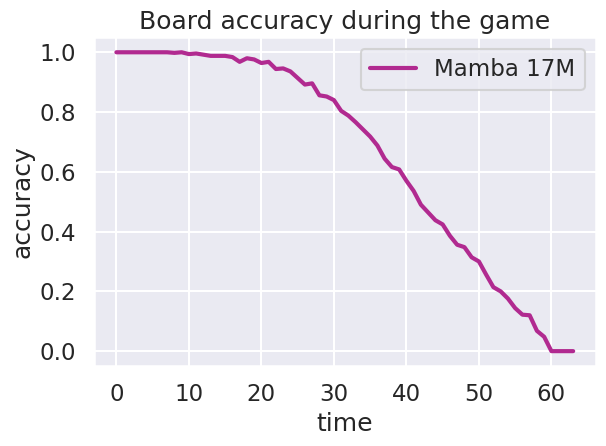

In [11]:
cmap = cm.plasma
colors = [cmap(0.7), cmap(0.9), cmap(0.2), cmap(0.4)]

# 3 : 17M Mamba - stoic-lion-30

sns.set_theme('talk')

ax = sns.lineplot(board_accuracies, color=colors[3], linewidth=3, label="Mamba 17M")

ax.set_title('Board accuracy during the game', fontsize=18)
ax.set_xlabel('time')
ax.set_ylabel('accuracy')

plt.tight_layout()
plt.savefig("acc_through_game.png", dpi=600)

In [63]:
# board reconstruction

In [98]:
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['green', 'white', 'black'])

In [83]:
moves = []
boards = []

game = OthelloGame()
for _ in range(60):
    legal_moves = game.get_valid_moves()
    if legal_moves == []:
        break

    move = random.choice(legal_moves)
    game.play_move(move)
    moves.append(move)
            
    board = torch.from_numpy(game.state.copy()).flatten()
    if game.next_hand_color == -1:
        board[board == 1] = 2
        board[board == -1] = 1
    else:
        board[board == -1] = 2
    boards.append(board)

x = torch.tensor(moves)+1
x = x.to(device).unsqueeze(0)
activations = model.forward_up_to(x, layer) # (B=1, lengame, d_model)

preds = torch.argmax(probe(activations).view(-1, 64, 3), dim=-1)
boards = torch.cat(boards).to(device).view(-1, 64)

# preds and boards are (lengame, 64)

acc = torch.all(torch.eq(preds, boards), dim=1) # (lengame)

In [84]:
acc.nonzero()

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 6],
        [17],
        [19],
        [23],
        [25],
        [26],
        [37],
        [38]], device='cuda:0')

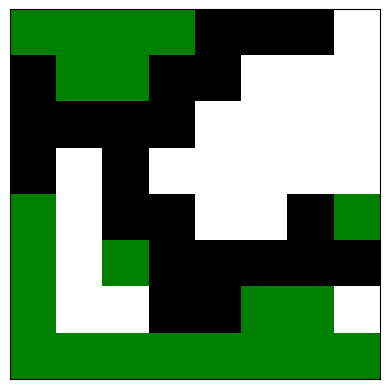

In [104]:
plt.imshow(preds[38].cpu().view(8, 8), cmap=cmap)
plt.xticks([])
plt.yticks([])

# save here
plt.savefig('board_recon.png', dpi=600)

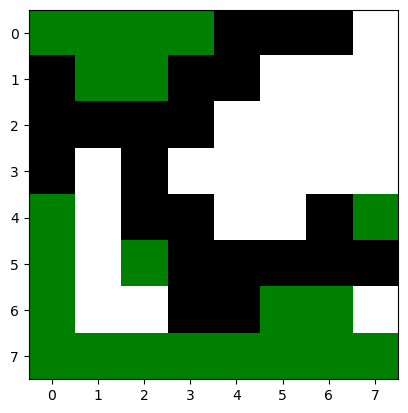

In [100]:
plt.imshow(boards[38].cpu().view(8, 8), cmap=cmap)